In [1]:
%load_ext autoreload
%autoreload 2

# Introduction 

This is the baseline model run on train and validation to give a baseline value to compare against. 
We use the combined strings column and the default blair model as the embedder. 

# Imports 

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import pickle

from utils.setup_nodes import create_edge_lists, create_user_df
from utils.graph_helpers import train_model, plot_train_val_loss, final_evaluation, plot_activation_heatmap_and_density
from utils.graph_model import Base_GNN_Model
from utils.general import seed_everything
from utils.predictions import recommend_products, pretty_print_recomendations, get_top_k_preds

# Set seed

In [3]:
seed_everything()

# Set variables 

In [4]:
user_split = "train_test_valid"
prod_embed_name = "title_features_base"
user_embed_name = "user_reviews_features_base"

data_dir = "data"
product_dir = "full_data"
embedding_dir = "embedding"
results_folder = "baseline_with_hooks"

device = "cuda"

product_cols = ["parent_asin", "average_rating", "rating_number"]
user_cols = ["user_id", "rating_mean", "rating_count", "helpful_vote_mean", "helpful_vote_gte_1", "verified_purchase_mean", "last_active_in_days_min",
            "last_active_in_days_max", "word_count_mean"]
edge_cols = ["user_id", "parent_asin", "rating"]

# Load data

In [5]:
product_df = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = product_cols)
train_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/train_agg.parquet", columns = user_cols)
train_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/train.parquet", columns = edge_cols)

if user_split == "train_test_valid":
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/valid_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/valid.parquet", columns = edge_cols)
else:
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/test_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/test.parquet", columns = edge_cols)


In [6]:
product_embedding = torch.load(f"{data_dir}/{embedding_dir}/product/{prod_embed_name}.pt")
train_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/train_{user_embed_name}.pt")
if user_split == "train_test_valid":
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/valid_{user_embed_name}.pt")
else:
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/test_{user_embed_name}.pt")

# Make nodes

In [7]:
# Add the embedding 
train_user_df["embedding"] = list(train_user_embedding.numpy())
test_user_df["embedding"] = list(test_user_embedding.numpy())

# Make super user df
user_df = create_user_df(train_user_df, test_user_df)

In [8]:
# Set up id mapping
offset = user_df.user_id.nunique()
user_id_to_idx = {unique_id : idx for idx, unique_id in enumerate(user_df.user_id.unique())}
prod_id_to_idx = {unique_id : offset + idx for idx, unique_id in enumerate(product_df.parent_asin.unique())}

# Add to df
product_df["prod_idx"] = product_df.parent_asin.apply(lambda x: prod_id_to_idx[x])
train_user_edges["user_idx"] = train_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
test_user_edges["user_idx"] = test_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
train_user_edges["prod_idx"] = train_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])
test_user_edges["prod_idx"] = test_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])

In [9]:
# Concat product nodes 
product_nodes = torch.cat([torch.tensor(product_df.drop(["parent_asin", "prod_idx"], axis = 1).to_numpy()), product_embedding], dim = 1)

In [10]:
# concat user nodes 
user_embed = torch.tensor(np.vstack(user_df["embedding"].values))
user_info = torch.tensor(user_df.drop(["user_id", "embedding"], axis = 1).to_numpy())
user_nodes = torch.cat([user_info, user_embed], dim = 1)

In [11]:
# Create edge list
train_edge_index, train_edge_weights = create_edge_lists(train_user_edges)
test_edge_index, test_edge_weights = create_edge_lists(train_user_edges)

# Move to GPU 

In [12]:
product_nodes = product_nodes.type(torch.float).to(device)
user_nodes = user_nodes.type(torch.float).to(device)
train_edge_index = train_edge_index.to(device)
train_edge_weights = train_edge_weights.to(device)
test_edge_index = test_edge_index.to(device)
test_edge_weights = test_edge_weights.to(device)

# Instantiate the model

In [13]:
# Set up model features
num_users = len(user_df)
num_products = len(product_df)
user_feature_dim = user_nodes.shape[1]
product_feature_dim = product_nodes.shape[1]
embedding_dim = 64

In [14]:
# Instantiate the model
model = Base_GNN_Model(num_users, num_products, user_feature_dim, product_feature_dim, embedding_dim)

In [15]:
# move the model 
model.to(device)

Base_GNN_Model(
  (user_embedding): Embedding(383703, 64)
  (product_embedding): Embedding(89060, 64)
  (user_feature_transform): Linear(in_features=776, out_features=64, bias=True)
  (product_feature_transform): Linear(in_features=770, out_features=64, bias=True)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (predictor): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

# Add hooks 

In [16]:
# Record activations for visualization
activations = {}  # Dictionary to store activations
def hook_fn(module, input, output):
    """Hook function to capture activations."""
    activations[module] = output
hook_handle_1 = model.conv1.register_forward_hook(hook_fn)
hook_handle_2 = model.conv2.register_forward_hook(hook_fn)
hook_handle_3 = model.user_feature_transform.register_forward_hook(hook_fn)
hook_handle_4 = model.product_feature_transform.register_forward_hook(hook_fn)

# Train the model 

In [17]:
train_loss, test_loss, best_model = train_model(model, train_edge_index, train_edge_weights, test_edge_index, test_edge_weights, 
                                                 user_nodes, product_nodes, num_epochs = 1000, print_progress=True, print_freq=100)

Epoch: 100, Train Loss: 4.7409, Val Loss: 4.4702, best model epoch: 87
Epoch: 200, Train Loss: 4.3016, Val Loss: 4.4455, best model epoch: 162
Epoch: 300, Train Loss: 4.3407, Val Loss: 4.4074, best model epoch: 299
Epoch: 400, Train Loss: 3.8721, Val Loss: 4.1241, best model epoch: 395
Epoch: 500, Train Loss: 3.2673, Val Loss: 2.9977, best model epoch: 494
Epoch: 600, Train Loss: 2.5892, Val Loss: 2.2226, best model epoch: 596
Epoch: 700, Train Loss: 2.1240, Val Loss: 1.8520, best model epoch: 699
Epoch: 800, Train Loss: 2.1711, Val Loss: 2.0358, best model epoch: 764
Epoch: 900, Train Loss: 2.5043, Val Loss: 2.2729, best model epoch: 875
Epoch: 1000, Train Loss: 1.7026, Val Loss: 1.5158, best model epoch: 991


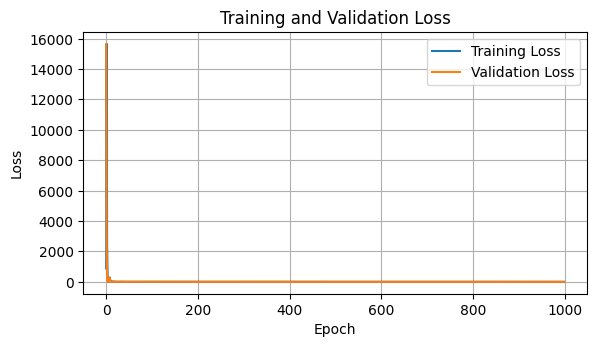

In [18]:
plot_train_val_loss(train_loss, test_loss)

In [20]:
os.makedirs(f"results/{results_folder}", exist_ok=True)
torch.save(train_loss, f"results/{results_folder}/train_loss.pt")
torch.save(test_loss, f"results/{results_folder}/test_loss.pt")

pickle.dump(activations, open(f"results/{results_folder}/activations.pkl", "wb"))

# Best model performance 

Note this is on the validation set 

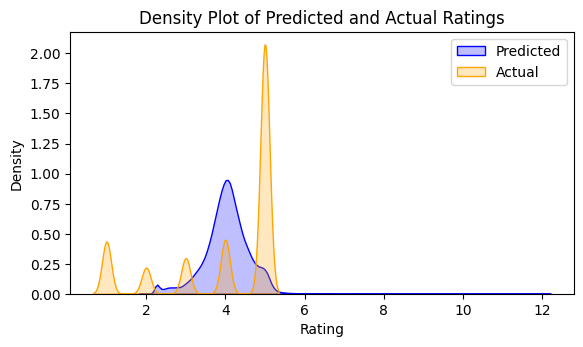

1.4968143701553345


In [21]:
model.load_state_dict(best_model)
best_loss, predictions = final_evaluation(model, test_edge_index, test_edge_weights, user_nodes, product_nodes, device, plot = True, print_test = False)
print(best_loss.item())

In [22]:
torch.save(predictions, f"results/{results_folder}/predictions.pt")
torch.save(model.state_dict(), f"results/{results_folder}/model.pt")

# Analysing predictions

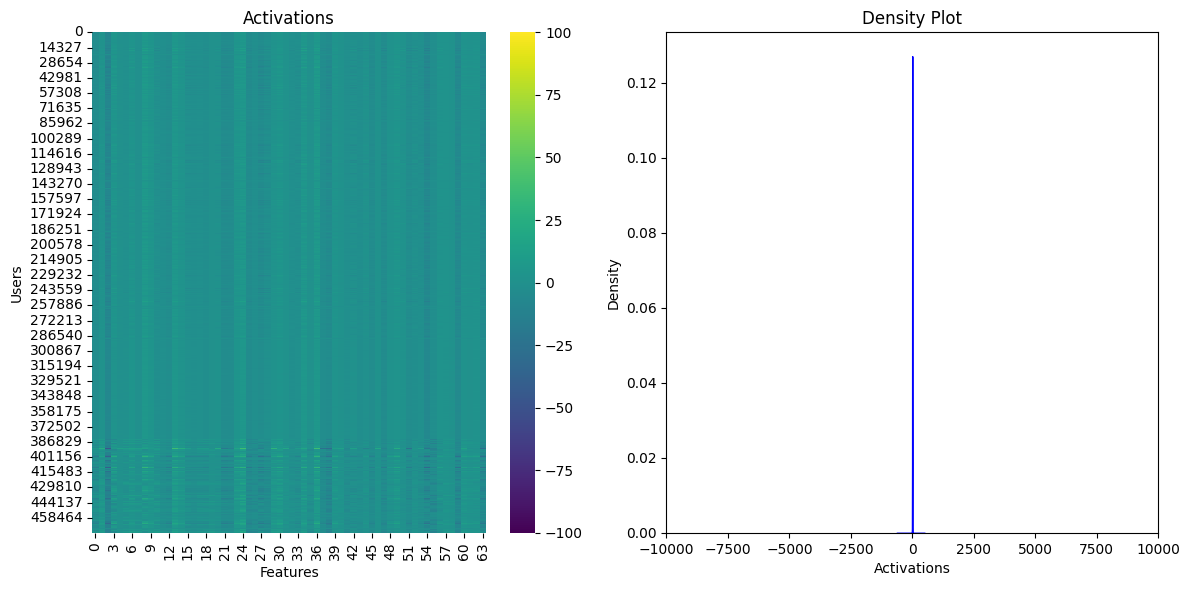

In [23]:
# Visualize activations of conv2 activation output
activations_of_interest = activations[model.conv2].detach().cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

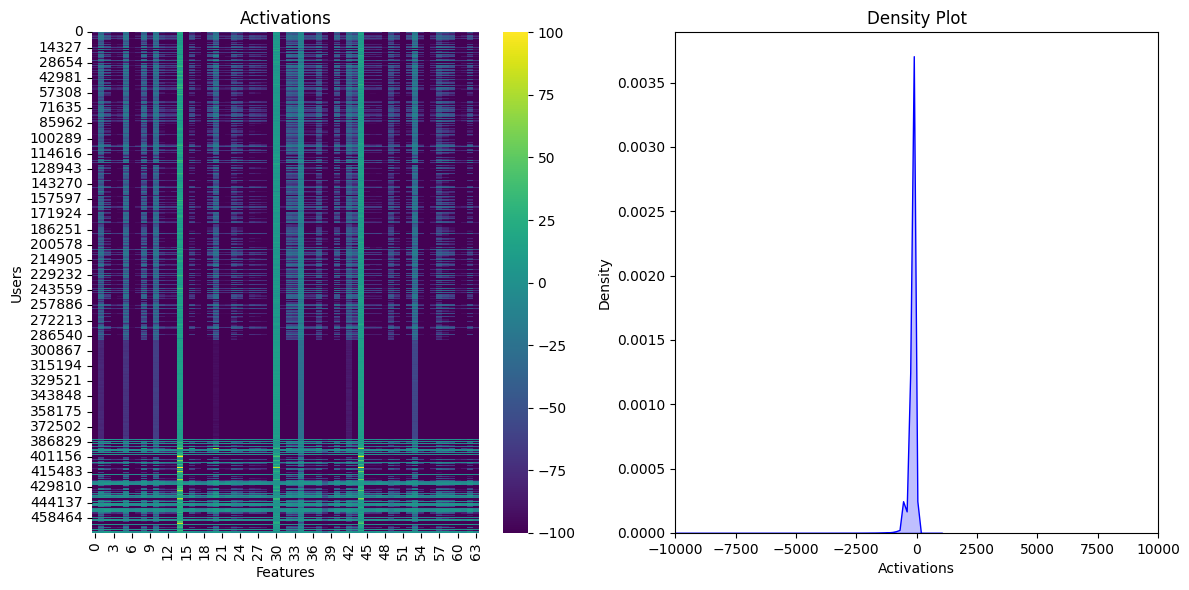

In [24]:
# Visualize activations of conv1 activation output
activations_of_interest = activations[model.conv1].detach().cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

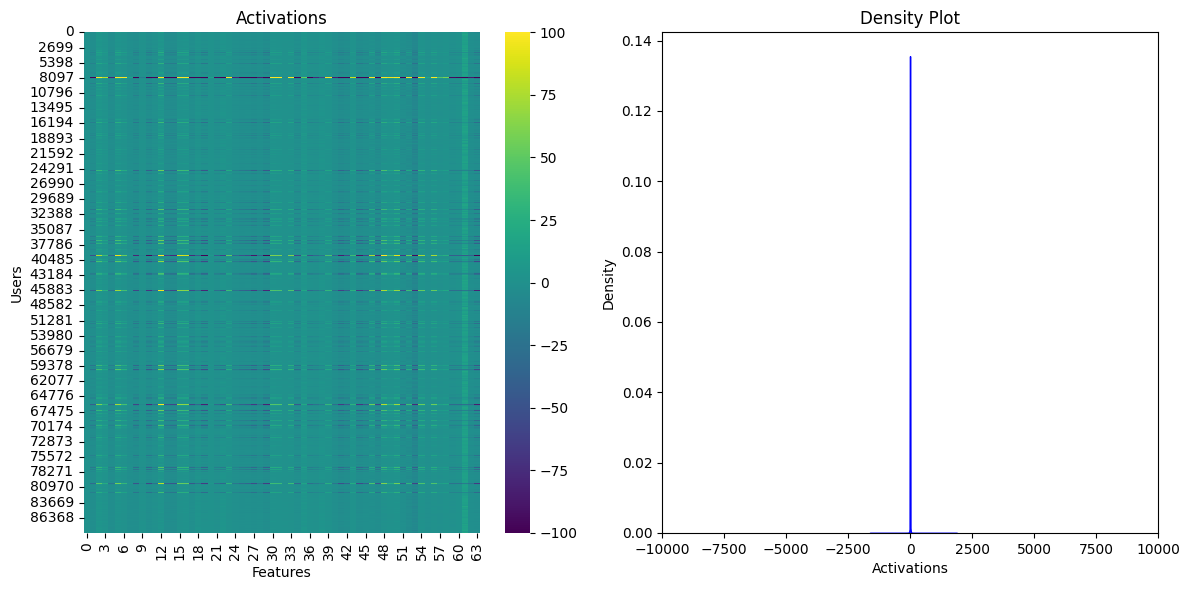

In [25]:
# Visualize activations of product_feature_transform activation output
activations_of_interest = activations[model.product_feature_transform].cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

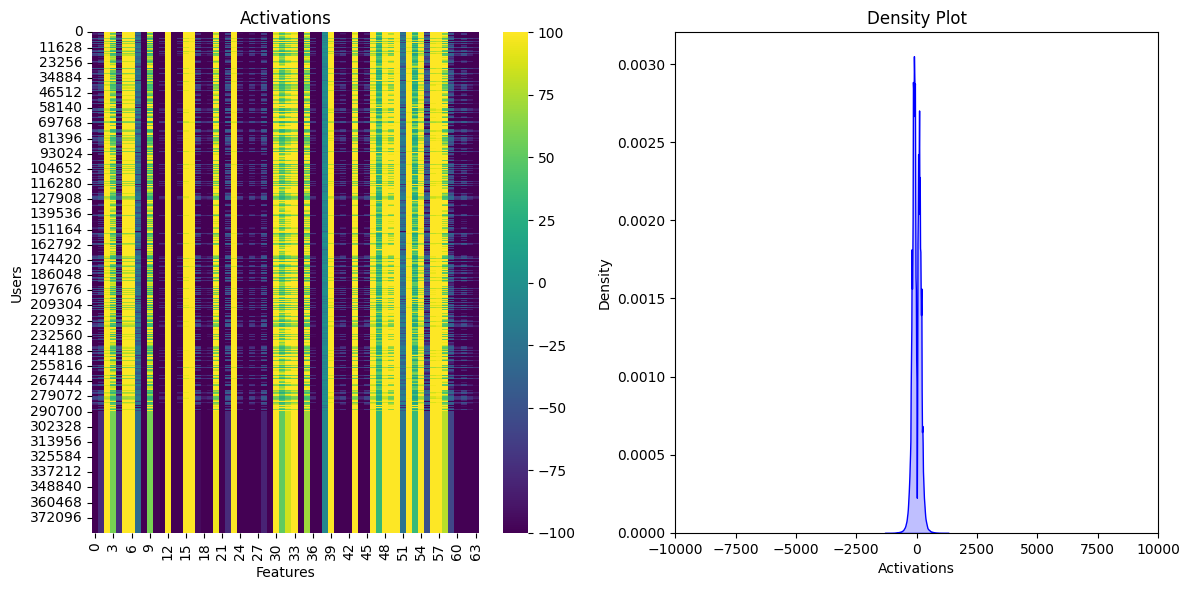

In [26]:
# Visualize activations of user_feature_transform activation output
activations_of_interest = activations[model.user_feature_transform].cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

# Metrics 

In [27]:
product_idx_tensor = torch.tensor(list(prod_id_to_idx.values()), dtype=torch.long, device = device)
test_edges_grp = test_user_edges.groupby("user_idx").prod_idx.apply(list).reset_index()
test_edges_users = test_edges_grp.user_idx.to_list()

In [28]:
predictions = get_top_k_preds(model, test_edges_users, 10, 32, user_nodes, product_nodes, product_idx_tensor, device) # about 5 min to run
test_edges_grp["prediction"] = list(torch.vstack(predictions).cpu().numpy())
test_edges_grp["match_count"] = test_edges_grp.apply(lambda x: len(set(x.prod_idx).intersection(set(x.prediction))), axis = 1)

In [29]:
# Overall recall
(test_edges_grp["match_count"] / test_edges_grp.prod_idx.apply(len)).mean()

np.float64(0.0)

In [30]:
# Only those with prior history 
existing_test_edges_grp = test_edges_grp[test_edges_grp.user_idx.isin(train_user_df.user_id.apply(lambda x: user_id_to_idx[x]))]
(existing_test_edges_grp["match_count"] / existing_test_edges_grp.prod_idx.apply(len)).mean()

np.float64(0.0)

In [31]:
test_edges_grp.to_parquet(f"results/{results_folder}/predictions.parquet")

# Show sample recomendations 

In [32]:
title_mapping = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = ["parent_asin", "title"])
prod_idx_to_id = {idx - offset: asin for asin, idx in prod_id_to_idx.items()}

In [33]:
# The pure random 
user_id = test_user_df.user_id.sample(1).item()
recommended_products, predictions = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")

Product 1: Ponytail Human Hair Extensions 18inch 90g #02 Dark Brown
Product 2: SH30 Replacement Blades for Compatible with Norelco Shaver,SH52 Replacement Shaver Heads with Brush for Series 1000, 2000, 3000 Shavers and S738 Click and Style
Product 3: Mink Eyelashes 3D Mink Lashes 25mm Lashes Extension Volume Handmade Natural Eyelashes(X15) Ruairie
Product 4: Afro Kinky Curly Clip in for American Lady 12.1" #126
Product 5: ENTRANCED STYLES Long Wavy Bob Wig Curly Afro Wig Synthetic Lace Front Wigs for Black Women Middle Part Heat Resistant Natural Looking Black Color Wig 14 Inch
Product 6: Glueless 613 Blonde 13X4 Lace Front Wigs Human Hair with Baby Hair Pre Plucked Peruvian Straight Lace Frontal Wig Can Be Dyed Honey Blonde Remy Lace Wigs For Women (20", straight)
Product 7: ULG Soak off UV LED Gel Nail Polish Set - 6 Color Collection Glitter Gel Polish Nail Art Manicure Gel Gift Box
Product 8: Sminiker Professional 4 in 1 Waterproof Women Electric Razor Set 3-Blade Cordless Precise B

In [34]:
# The user with some data 
existing_test_users = test_user_df[test_user_df.user_id.isin(train_user_df.user_id)].copy()[["user_id"]]

In [35]:
user_id = existing_test_users.user_id.sample(1).item()
recommended_products, predictions = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")

Product 1: Ponytail Human Hair Extensions 18inch 90g #02 Dark Brown
Product 2: SH30 Replacement Blades for Compatible with Norelco Shaver,SH52 Replacement Shaver Heads with Brush for Series 1000, 2000, 3000 Shavers and S738 Click and Style
Product 3: Afro Kinky Curly Clip in for American Lady 12.1" #126
Product 4: Mink Eyelashes 3D Mink Lashes 25mm Lashes Extension Volume Handmade Natural Eyelashes(X15) Ruairie
Product 5: ENTRANCED STYLES Long Wavy Bob Wig Curly Afro Wig Synthetic Lace Front Wigs for Black Women Middle Part Heat Resistant Natural Looking Black Color Wig 14 Inch
Product 6: ULG Soak off UV LED Gel Nail Polish Set - 6 Color Collection Glitter Gel Polish Nail Art Manicure Gel Gift Box
Product 7: AMA(TM) Toddler Kids Girls Off Shoulder Party Dress Summer Bohemian Dresses (2T, Multicolor)
Product 8: Sminiker Professional 4 in 1 Waterproof Women Electric Razor Set 3-Blade Cordless Precise Bikini Trimmer Rechargeable Electric Shaver for Women Arm Underarm Bikini Line Legs
Prod